# Расчет площадей лесных пожаров

In [119]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import random
import sklearn

# importing sklearn libraries
from sklearn import neural_network, linear_model, preprocessing, svm, tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoLarsCV
from sklearn.linear_model import Lasso
%matplotlib inline

# Загрузка данных

В данные входят следующие величины:

    X - Пространственная координата оси X на карте парка Монтезиньо: от 1 до 9
    Y - Пространственная координата оси X на карте парка Монтезиньо: от 2 до 9
    month - название месяца: "jan" до "dec"
    day - день недели: "mon" до "sun"
    FFMC - FFMC-индекс FWI-системы: от 18.7 до 96.20
    DMC - DMC-индекс FWI-системы: от 1.1 до 291.3
    DC - DC-индекс FWI-системы: от 7.9 до 860.6
    ISI - ISI-индекс FWI-системы: от 0.0 до 56.10
    temp - температура воздуха в Цельсиях: от 2.2 до 33.30
    RH - относительная влажность в%: от 15.0 до 100
    wind - скорочть ветра в км/ч: от 0.40 до 9.40
    rain - количество осадков в мм/м2: от 0.0 до 6.4
    area - размер территории леса, охваченной огнем(в гектарах): от 0.00 до 1090.84


In [120]:
forest_fires = pd.read_csv('forestfires.csv')

In [121]:
forest_fires.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


# Статистический анализ данных

Рассмотрим значение стандартных статистических величин у каждого из данных признаков, а так же попарную корелляцию

In [122]:
forest_fires.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


In [123]:
# Попарная корелляция между признаками
forest_fires.corr()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
X,1.000000,0.539548,-0.021039,-0.048384,-0.085916,0.006210,-0.051258,0.085223,0.018798,0.065387,0.063385
Y,0.539548,1.000000,-0.046308,0.007782,-0.101178,-0.024488,-0.024103,0.062221,-0.020341,0.033234,0.044873
FFMC,-0.021039,-0.046308,1.000000,0.382619,0.330512,0.531805,0.431532,-0.300995,-0.028485,0.056702,0.040122
DMC,-0.048384,0.007782,0.382619,1.000000,0.682192,0.305128,0.469594,0.073795,-0.105342,0.074790,0.072994
DC,-0.085916,-0.101178,0.330512,0.682192,1.000000,0.229154,0.496208,-0.039192,-0.203466,0.035861,0.049383
ISI,0.006210,-0.024488,0.531805,0.305128,0.229154,1.000000,0.394287,-0.132517,0.106826,0.067668,0.008258
temp,-0.051258,-0.024103,0.431532,0.469594,0.496208,0.394287,1.000000,-0.527390,-0.227116,0.069491,0.097844
RH,0.085223,0.062221,-0.300995,0.073795,-0.039192,-0.132517,-0.527390,1.000000,0.069410,0.099751,-0.075519
wind,0.018798,-0.020341,-0.028485,-0.105342,-0.203466,0.106826,-0.227116,0.069410,1.000000,0.061119,0.012317
rain,0.065387,0.033234,0.056702,0.074790,0.035861,0.067668,0.069491,0.099751,0.061119,1.000000,-0.007366


# Линейная модель

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Значение весов и параметр регуляризации

Для начала расчитаем коэффициенты регрессии в нашей модели и поймем все ли признаки имеют некоторый вес в нашей модели

In [125]:
est = LassoLarsCV(cv=10, precompute=False).fit(X_train, y_train)
est.coef_

array([0.        , 0.        , 0.        , 0.01194366, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

Как мы видим в данной модели только 1 признак имеет некоторый вес. Этот признак - DMC. Построим график зависимости веса от параметра регуляризации

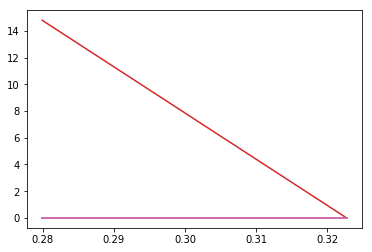

In [126]:
est.alphas_
alphas = est.alphas_
plt.plot(alphas, est.coef_path_.T);

#  Зависимости общей ошибки от параметра регуляризации

In [127]:
X = pd.get_dummies(X, drop_first=True)

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [129]:
errors = []
for i in np.linspace(1e-1, 1e+2, 30):
    est = sklearn.linear_model.Lasso(alpha=i)
    errors.append(sklearn.model_selection.cross_val_score(est, X, y).mean()**2)

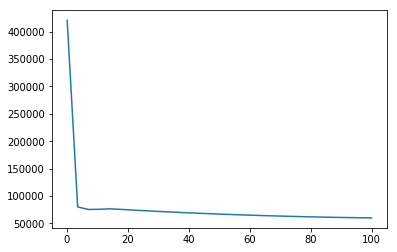

In [130]:
plt.plot(np.linspace(1e-1, 1e+2, 30), errors);

# Зависимость ошибки от числа признаков

In [131]:
mses1 = []
mses2 = []
for i in range(1,13):
    est=Lasso(alpha=10)
    est.fit(X_train.iloc[:,0:i],y_train)
    predictions = est.predict(X_test.iloc[:,0:i])
    mses1 = np.append(mses1, [mean_squared_error(y_test, predictions)])

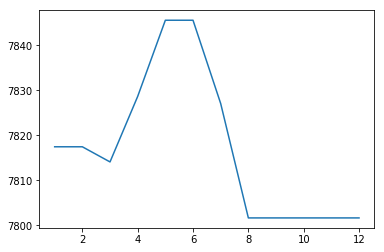

In [132]:
plt.figure()
plt.plot(range(1,13), mses1);

# Вывод

Как говорилось уже в самом описании к этим данным - такого количества недостатосно для описания полноценной линейной модели. Как мы видим она чаще ошибается чем оказывается права, что не является хорошим показателем данной модели. Однако, как мы видим, она выдает постоянный уровень ошибки при 8 и более признаках.